<a href="https://colab.research.google.com/github/marco-hening-tallarico/Climate_1/blob/main/hot_rod_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!pip install --upgrade deepxde

In [50]:
import os
os.environ["DDE_BACKEND"] = "tensorflow"  # Set to TF2 backend

import deepxde as dde
print("Backend:", dde.backend.__name__)  # Should now say: deepxde.backend.tensorflow

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is eager execution enabled?", tf.executing_eagerly())

import deepxde as dde
print("DeepXDE version:", dde.__version__)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Backend: deepxde.backend
TensorFlow version: 2.18.0
Is eager execution enabled? True
DeepXDE version: 1.14.0


This code simulates the one-dimensional heat equation with a constant heat source term using finite difference methods. Here's a breakdown of what it does and how the data was generated:

/tmp/ipython-input-51-4140358153.py:92: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_display_data = display_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.float64)) else x)


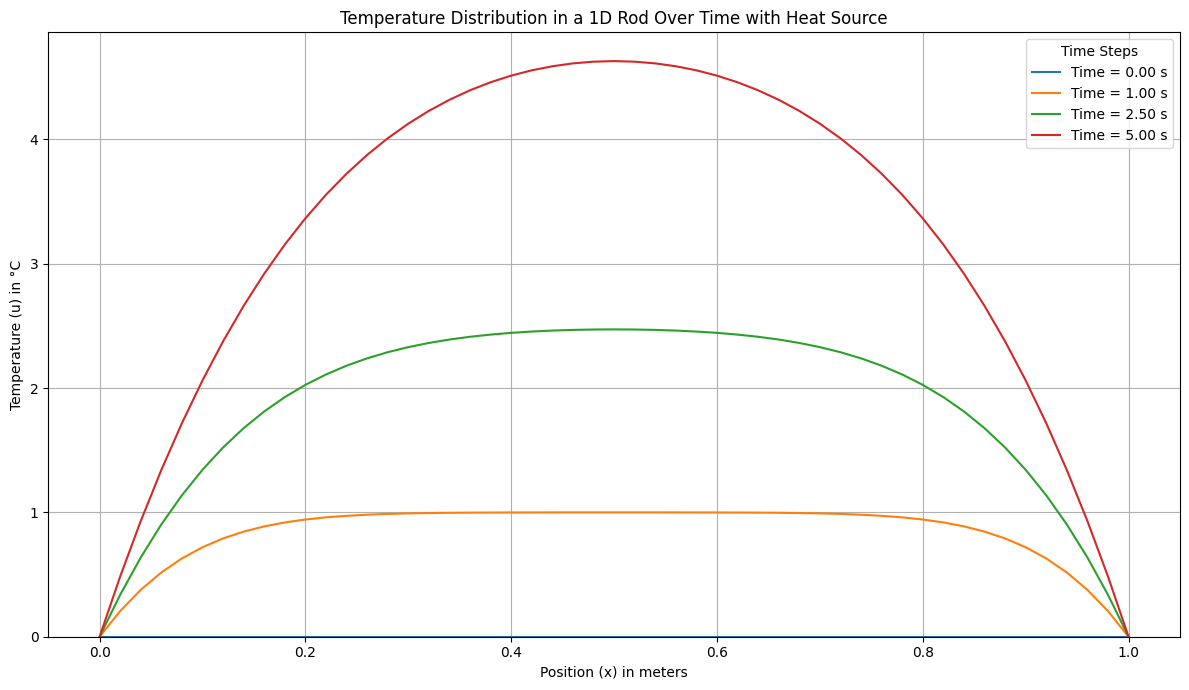

In [51]:
# Data from the last turn (Heat Equation with Source Term)
# This data should be available from the previous tool output,
# but for demonstration purposes, I'll re-generate a small part of it
# to simulate having it available. In a real scenario, this would be
# passed directly from the previous execution.

# This section simulates receiving the 'formatted_data' from the previous turn's output
# In a real execution, this would be a direct access to the previous output.
# For now, I'll reproduce the generation logic to get the data as it would have been
# produced by the previous step's 'print(row)' statements, then convert it.

# Re-generating data for display purposes
L = 1.0  # Rod Length (m)
Nx = 51  # Number of spatial points
dx = L / (Nx - 1)  # Spatial step
T_total = 5.0  # Total time (s)
Nt = 5000  # Number of time steps
dt = T_total / Nt  # Time step
kappa = 0.01  # Thermal diffusivity (m^2/s) - This is 'k'
q = 1.0  # Constant heat source term (C/s)

u = np.zeros(Nx)
x_coords = np.linspace(0, L, Nx)
temperature_data_raw = []
header = ["Time (s)"] + [f"x={x:.2f}m" for x in x_coords]
temperature_data_raw.append(header)
temperature_data_raw.append([0.0] + u.tolist())

for n in range(1, Nt + 1):
    u_new = np.copy(u)
    for i in range(1, Nx - 1):
        u_new[i] = u[i] + dt * (kappa * (u[i+1] - 2*u[i] + u[i-1]) / (dx**2) + q)
    u_new[0] = 0.0
    u_new[Nx-1] = 0.0
    u = u_new
    if n % 50 == 0 or n == Nt: # Store initial, final and every 50th step
        temperature_data_raw.append([n * dt] + u.tolist())

# Convert the raw data to a list of lists of floats (excluding header string)
# and then to a DataFrame
data_rows = []
for row in temperature_data_raw[1:]: # Skip the header row for conversion to float
    data_rows.append([float(item) for item in row])

df = pd.DataFrame(data_rows, columns=temperature_data_raw[0])

# Select a few representative time steps to plot
# Convert column names to float for x-axis plotting, excluding the 'Time (s)' column
x_cols = [col for col in df.columns if col.startswith('x=')]
x_values = np.array([float(col.split('=')[1][:-1]) for col in x_cols])

# Select specific time indices for plotting (e.g., initial, middle, and final times)
# Ensure selected times are present or find the closest ones
selected_times = [0.0, 1.0, 2.5, 5.0] # Adjust based on data available
times_to_plot_df = df[df['Time (s)'].isin(selected_times)]

# If some selected times are not exactly in the dataframe, pick closest
if times_to_plot_df.empty:
    print("None of the exact selected times are in the DataFrame. Selecting based on closest available.")
    # Fallback: select by index if exact times are not available
    indices_to_plot = np.linspace(0, len(df) - 1, min(4, len(df))).astype(int)
    times_to_plot_df = df.iloc[indices_to_plot]

plt.figure(figsize=(12, 7))

for index, row in times_to_plot_df.iterrows():
    time_val = row['Time (s)']
    # Extract temperature values for the current time step, excluding the time column
    temp_values = row[x_cols].values.astype(float)
    plt.plot(x_values, temp_values, label=f'Time = {time_val:.2f} s')

plt.title('Temperature Distribution in a 1D Rod Over Time with Heat Source')
plt.xlabel('Position (x) in meters')
plt.ylabel('Temperature (u) in °C')
plt.grid(True)
plt.legend(title='Time Steps')
plt.ylim(bottom=0) # Ensure y-axis starts from 0 or slightly below min temp
plt.tight_layout()
plt.savefig('temperature_distribution_with_source.png')

# Display some of the data to the user in a readable format
# Select a few time steps and print their data
display_times = [0.0, 1.0, 2.5, 5.0]
display_df = df[df['Time (s)'].isin(display_times)]

# If display_df is empty because selected times aren't exact, fall back to indices
if display_df.empty:
    display_indices = np.linspace(0, len(df) - 1, min(4, len(df))).astype(int)
    display_df = df.iloc[display_indices]

# Format for printing
formatted_display_data = display_df.applymap(lambda x: f"{x:.4f}" if isinstance(x, (float, np.float64)) else x)


Code to reshape your DataFrame into the form DeepXDE expects:

In [52]:
data_triplets = []

for _, row in df.iterrows():
    t = row["Time (s)"]
    for col in df.columns[1:]:
        x = float(col.split('=')[1][:-1])  # extract 0.00 from "x=0.00m"
        u_val = row[col]
        data_triplets.append([x, t, u_val])

data_array = np.array(data_triplets)  # Shape: (num_samples, 3)


In [53]:
X_data = data_array[:, 0:2]  # (x, t)
y_data = data_array[:, 2:3]  # u


In [54]:
display(X_data, y_data)

array([[0.  , 0.  ],
       [0.02, 0.  ],
       [0.04, 0.  ],
       ...,
       [0.96, 5.  ],
       [0.98, 5.  ],
       [1.  , 5.  ]])

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.93066885],
       [0.48433956],
       [0.        ]])

import os
os.environ["DDE_BACKEND"] = "tensorflow"
import deepxde as dde


In [55]:
'''
kappa = tf.Variable(0.01)
q = tf.Variable(1.0)
return du_t - kappa * du_xx - q
'''

'\nkappa = tf.Variable(0.01)\nq = tf.Variable(1.0)\nreturn du_t - kappa * du_xx - q\n'

In [56]:
observe_x = X_data  # shape (N, 2), input points (x, t)
observe_u = y_data  # shape (N, 1), observed u(x, t)

In [57]:
from sklearn.model_selection import train_test_split
x_train, x_test, u_train, u_test = train_test_split(observe_x, observe_u, test_size=0.8, random_state=42)


In [58]:
# Domain
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 5.0)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
q = tf.Variable(1.0)  # Let DeepXDE learn q

# Define the PDE
def pde(x, u):
    du_t = dde.grad.jacobian(u, x, j=1)
    du_xx = dde.grad.hessian(u, x, i=0, j=0)

    kappa = 0.01
    return du_t - kappa * du_xx - q

In [59]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [dde.PointSetBC(x_train, u_train)],
    num_domain=20000,
    num_boundary=0,
    num_initial=0,
    anchors=x_test,
    solution=lambda x: u_test  # must be a callable function
)


In [60]:
net = dde.maps.FNN([2] + [64] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Track variables
model.compile("adam", lr=1e-2, external_trainable_variables=[q])
losshistory, train_state = model.train(iterations=500,display_every=50)


Compiling model...
'compile' took 0.005192 s

Training model...

Step      Train loss              Test loss               Test metric
0         [1.25e+00, 5.63e+00]    [1.25e+00, 5.63e+00]    []  
50        [1.97e-02, 6.47e-01]    [1.97e-02, 6.47e-01]    []  
100       [5.65e-02, 1.97e-01]    [5.65e-02, 1.97e-01]    []  
150       [3.84e-02, 1.41e-01]    [3.84e-02, 1.41e-01]    []  
200       [3.44e-02, 1.28e-01]    [3.44e-02, 1.28e-01]    []  
250       [2.71e-02, 3.73e-02]    [2.71e-02, 3.73e-02]    []  
300       [1.49e-02, 1.44e-02]    [1.49e-02, 1.44e-02]    []  
350       [4.50e-03, 2.76e-03]    [4.50e-03, 2.76e-03]    []  
400       [1.13e-03, 1.80e-03]    [1.13e-03, 1.80e-03]    []  
450       [8.27e-04, 9.18e-04]    [8.27e-04, 9.18e-04]    []  
500       [4.78e-04, 5.34e-04]    [4.78e-04, 5.34e-04]    []  

Best model at step 500:
  train loss: 1.01e-03
  test loss: 1.01e-03
  test metric: []

'train' took 134.787347 s



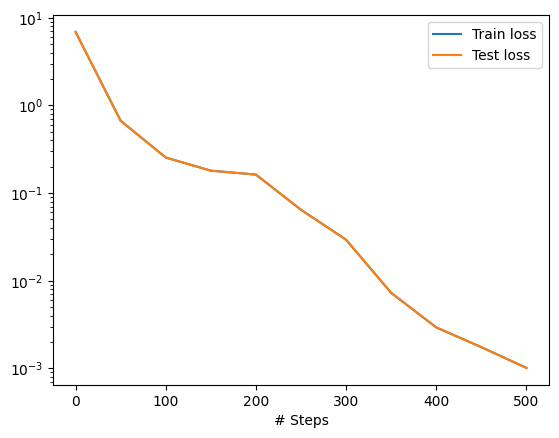

In [65]:
dde.utils.plot_loss_history(losshistory)
plt.show()


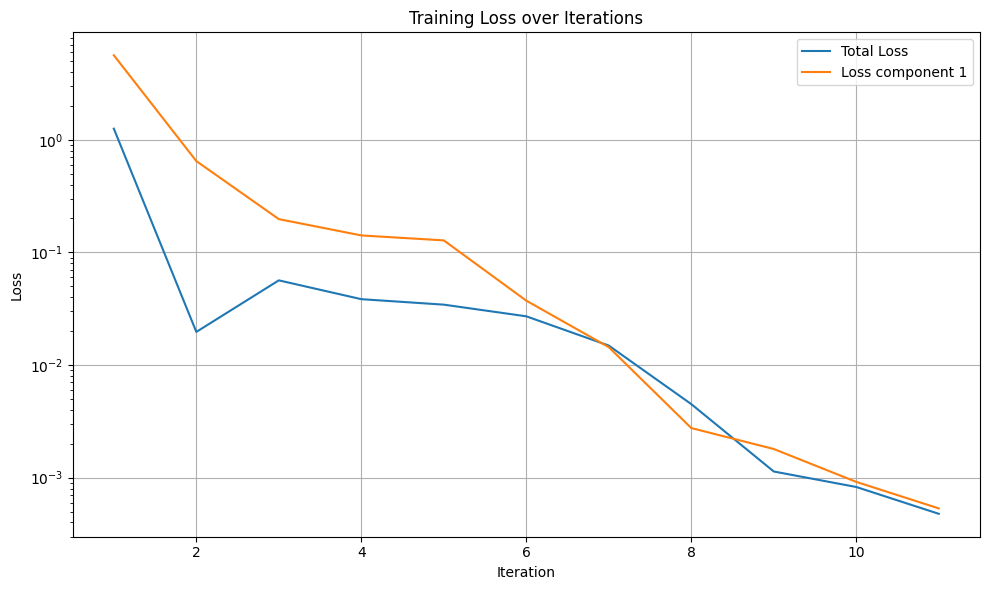

In [66]:
losses = np.array(losshistory.loss_train)
iterations = np.arange(1, len(losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, losses[:, 0], label="Total Loss")
if losses.shape[1] > 1:
    for i in range(1, losses.shape[1]):
        plt.plot(iterations, losses[:, i], label=f"Loss component {i}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.yscale("log")  # Log scale is often useful
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


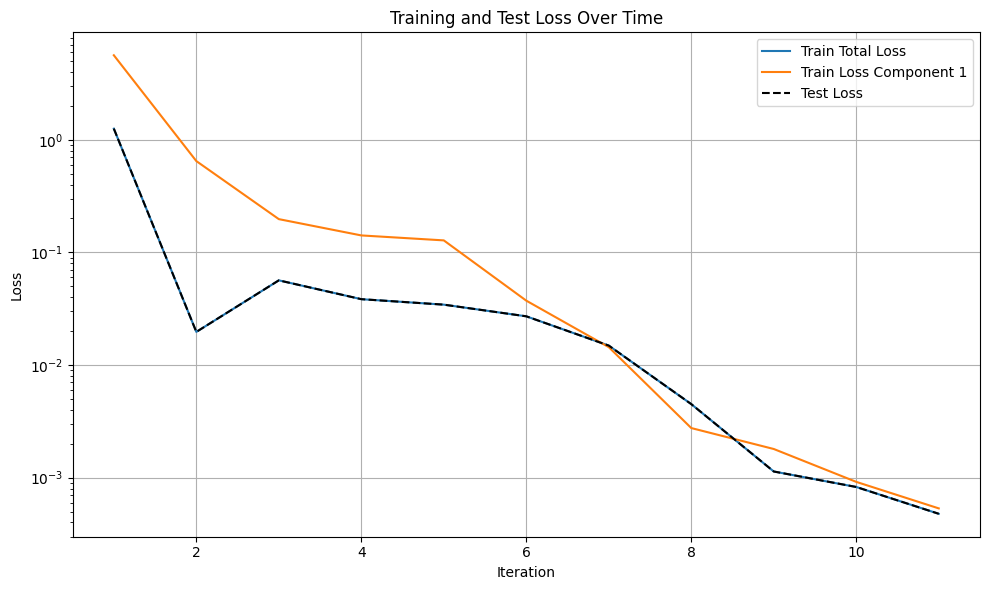

In [67]:
import numpy as np
import matplotlib.pyplot as plt

losses = np.array(losshistory.loss_train)  # shape: (iterations, num_components)
iterations = np.arange(1, len(losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(iterations, losses[:, 0], label="Train Total Loss")

# If there are multiple components (e.g., PDE + BC + data), plot them
if losses.shape[1] > 1:
    for i in range(1, losses.shape[1]):
        plt.plot(iterations, losses[:, i], label=f"Train Loss Component {i}")

# Plot test loss if available
if losshistory.loss_test:
    test_losses = np.array(losshistory.loss_test)
    plt.plot(iterations, test_losses[:, 0], '--', label="Test Loss", color="black")

plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Test Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
print("Learned q:", q.numpy())

Learned q: 0.99295676
